In [13]:
# Import packages, access environment variables
import requests
from bs4 import BeautifulSoup
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
import collections    
import matplotlib.pyplot as plt   
from PIL import Image
from wordcloud import WordCloud
import nltk
nltk.download(["stopwords","vader_lexicon","punkt","wordnet"])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from numpy import asarray
from textblob import TextBlob
from dotenv import load_dotenv
import requests
import base64

url = "https://api.genius.com/search"

load_dotenv()

SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
SPOTIFY_CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')
GENIUS_API_TOKEN = os.getenv('GENIUS_API_TOKEN')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ashren/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ashren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ashren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Get artist from Genius API
def get_artist_info(artist_name, page):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    search_url = base_url + '/search'
    params = {'q': artist_name, 'per_page': 10, 'page': page}
    
    response = requests.get(search_url, params=params, headers=headers)
    
    # Check if the response status is OK (200)
    if response.status_code != 200:
        print(f"Error: {response.status_code} - {response.text}")
        return None
    
    # Try parsing the response as JSON, handle cases where it's not JSON
    try:
        return response.json()
    except ValueError:
        print(f"Response was not JSON: {response.text}")
        return None

# Get all Genius.com song URLs for a specific artist
def get_song_urls(artist_name):
    page = 1
    songs = []
    
    while True:
        response = get_artist_info(artist_name, page)
        
        # If there's an issue with the response, break the loop
        if response is None:
            print("Failed to fetch data. Breaking the loop.")
            break
        
        song_info = []
        
        # Collect song objects for the artist
        for hit in response['response']['hits']:
            primary_artist = hit['result']['primary_artist']['name'].lower()
            
            # Ensure the artist name exactly matches the primary artist name
            if primary_artist == artist_name.lower():
                song_info.append(hit)
    
        # Collect song URLs from song objects
        for song in song_info:
            url = song['result']['url']
            songs.append(url)
            
        # If no more results, break the loop
        if len(song_info) == 0:
            break
        
        # Increase the page count to fetch the next batch of results
        page += 1
    
    return songs

song_urls = get_song_urls('Lorde')

In [7]:
# Get title and lyrics from each song
def scrape_song_info(song_urls):
    song_data = []

    for url in song_urls:
        try:
            # Make a request to the song URL
            page = requests.get(url)
            page.raise_for_status()  # Raise an exception for bad responses
        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch {url}: {e}")
            song_data.append({'Song Title': 'Title Not Found', 'Lyrics': None})
            continue

        # Parse the HTML content with BeautifulSoup
        html = BeautifulSoup(page.text, 'html.parser')

        # Scrape the title
        title_tag = html.find('h1')
        if title_tag:
            title = title_tag.get_text().strip()
        else:
            title_tag = html.find('title')
            title = title_tag.get_text().split('|')[0].strip() if title_tag else "Title Not Found"

        # Scrape the lyrics
        lyrics_containers = html.find_all('div', class_=re.compile('Lyrics__Container'))
        lyrics = ' '.join([div.get_text(separator=" ").strip() for div in lyrics_containers])
        lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
        lyrics = ' '.join(lyrics.split()) if lyrics else None

        # Append the scraped data to the list
        song_data.append({'song_title': title, 'lyrics': lyrics})

    return song_data

# Example usage:
artist_name = 'Lorde'
song_urls = get_song_urls(artist_name)

# Scrape song titles and lyrics
song_info = scrape_song_info(song_urls)

# Convert the result to a DataFrame if needed
import pandas as pd
lorde_df = pd.DataFrame(song_info)

# View the resulting DataFrame
lorde_df.head()


,song_title,lyrics
0,Royals,I've never seen a diamond in the flesh I cut m...
1,Team,Wait till you're announced We've not yet lost ...
2,Liability,"Go for it One, two Baby really hurt me, crying..."
3,Green Light,I do my makeup in somebody else's car We order...
4,Ribs,"The drink you spilt all over me ""Lover's Spit""..."


In [9]:
# Exploratory data analysis

# Dropping rows with null values
lorde_df.info()
null_index = lorde_df[lorde_df['lyrics'].isnull()].index
lorde_df = lorde_df.drop(null_index)
lorde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_title  66 non-null     object
 1   lyrics      65 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 0 to 65
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_title  65 non-null     object
 1   lyrics      65 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [10]:
# Tokenize lyrics, remove punctuation, remove stop words

stop_words = stopwords.words('english')

def lyrics_tokenize(lyrics):
    # Tokenise words & ignore punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(lyrics)
    
    data_token=[token.lower() for token in tokens]
    processed_words= [w for w in data_token if not w in stop_words]
    return processed_words

lorde_df["tokenized_lyrics"] = [lyrics_tokenize(lyrics) for lyrics in lorde_df['lyrics']]
lorde_df.head()

,song_title,lyrics,tokenized_lyrics
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd..."
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou..."
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax..."
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different..."
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,..."


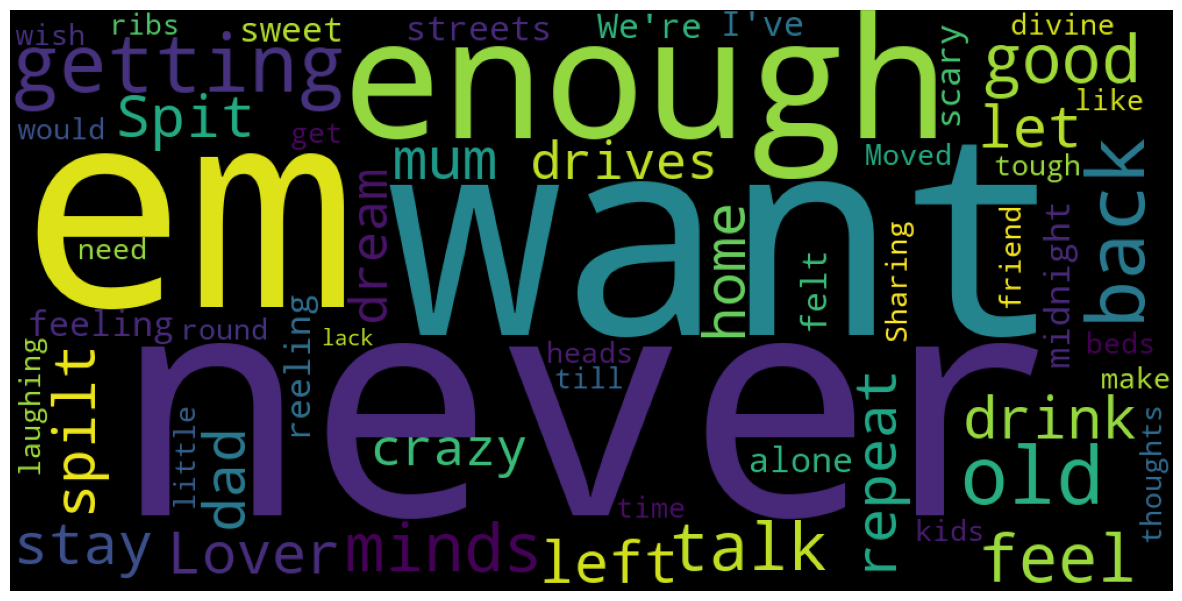

In [11]:
# Word cloud for Ribs

from collections import Counter

ribs_lyrics = lorde_df.loc[lorde_df['song_title']=="Ribs"]["lyrics"].values[0]

wordcloud = WordCloud(background_color='black', width = 1000, height = 500,collocations=False,random_state=100,stopwords=stop_words).generate(ribs_lyrics)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

# Generating word cloud image
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [12]:
# Turn column into string in order to apply polarity scores
lorde_df['new_tokenized_lyrics'] = [' '.join(map(str, l)) for l in lorde_df['tokenized_lyrics']]
lorde_df['sentiment'] = lorde_df['new_tokenized_lyrics'].apply(lambda tweet: TextBlob(tweet).sentiment)

# Processed song TEXTBLOB sentiment analysis
lorde_df['sentiment'] = lorde_df['new_tokenized_lyrics'].apply(lambda tweet: TextBlob(tweet).sentiment)
lorde_df.head(1)

# Split sentiment column into polarity and subjectivity
lorde_df['polarity'] = lorde_df['sentiment'].str.get(0)
lorde_df['subjectivity'] = lorde_df['sentiment'].str.get(1)
lorde_df = lorde_df.drop("sentiment", axis = 1)

lorde_df['sentiment'] = ''
lorde_df.loc[lorde_df.polarity > 0, 'sentiment'] = 'positive'
lorde_df.loc[lorde_df.polarity == 0, 'sentiment'] = 'neutral'
lorde_df.loc[lorde_df.polarity < 0, 'sentiment'] = 'negative'


lorde_df.head()

,song_title,lyrics,tokenized_lyrics,new_tokenized_lyrics,polarity,subjectivity,sentiment
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd...",never seen diamond flesh cut teeth wedding rin...,0.360262,0.638636,positive
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou...",wait till announced yet lost graces hounds sta...,0.268788,0.610000,positive
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax...",go one two baby really hurt crying taxi wanna ...,0.116111,0.418056,positive
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different...",makeup somebody else car order different drink...,0.177172,0.507980,positive
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,...",drink spilt lover spit left repeat mum dad let...,-0.009824,0.444309,negative


In [14]:
# Encode client ID and client secret for the Authorization header
client_creds = f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}"
client_creds_b64 = base64.b64encode(client_creds.encode()).decode()

# URL to request the access token
token_url = 'https://accounts.spotify.com/api/token'

# Headers and body for the token request
headers = {
    "Authorization": f"Basic {client_creds_b64}",
    "Content-Type": "application/x-www-form-urlencoded"
}
data = {
    "grant_type": "client_credentials"
}

# Send POST request to get the access token
response = requests.post(token_url, headers=headers, data=data)
token_response = response.json()

# Extract the access token
access_token = token_response.get('access_token')


In [15]:
# Spotify API base URL
base_url = "https://api.spotify.com/v1"

# Function to search for a track by name and artist
def search_track(access_token, track_name, artist_name):
    search_url = f"{base_url}/search"
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    params = {
        "q": f"track:{track_name} artist:{artist_name}",
        "type": "track",
        "limit": 1  # Limit to 1 track result to get the most relevant
    }
    
    response = requests.get(search_url, headers=headers, params=params)
    search_result = response.json()
    
    if search_result.get('tracks') and search_result['tracks']['items']:
        track = search_result['tracks']['items'][0]
        return track['id']  # Return the track ID
    else:
        return None


In [16]:
# Function to get audio features for a track by ID
def get_audio_features(access_token, track_id):
    audio_features_url = f"{base_url}/audio-features/{track_id}"
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    response = requests.get(audio_features_url, headers=headers)
    features = response.json()
    
    return features

In [17]:
song_titles = [list(d.values())[0] for d in song_info]
audio_features_collection = {}
unavailable_tracks = []

# Create list of songs that are not in Spotify
for song in song_titles:
    if search_track(access_token, song, 'Lorde') is None:
        unavailable_tracks.append(song)

songs_on_spotify = [song for song in song_titles if song not in unavailable_tracks]

# Extract audio features for each song
for song in songs_on_spotify:
    track_id = search_track(access_token, song, 'Lorde')
    if track_id:
        audio_features = get_audio_features(access_token, track_id)
        audio_features_collection[song]=audio_features

['Royals (Rick Ross Remix)', 'Precious Metals', 'Good Fights', 'Royals (The Elite Remix)', 'Lost Boys', 'Heartbreaking Love', 'Silver Moon*', 'Hold My Liquor', 'Team (HBK Gang Remix)', '“Yellow Flicker Beat” Single Art', 'Perfect Places (Whethan Remix)', 'Invisible Ink*', 'Sweet Dreams (Are Made of This)']
{'Royals': {'danceability': 0.674, 'energy': 0.426, 'key': 7, 'loudness': -9.504, 'mode': 1, 'speechiness': 0.122, 'acousticness': 0.12, 'instrumentalness': 0, 'liveness': 0.132, 'valence': 0.337, 'tempo': 84.876, 'type': 'audio_features', 'id': '2dLLR6qlu5UJ5gk0dKz0h3', 'uri': 'spotify:track:2dLLR6qlu5UJ5gk0dKz0h3', 'track_href': 'https://api.spotify.com/v1/tracks/2dLLR6qlu5UJ5gk0dKz0h3', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2dLLR6qlu5UJ5gk0dKz0h3', 'duration_ms': 190185, 'time_signature': 4}, 'Team': {'danceability': 0.691, 'energy': 0.578, 'key': 6, 'loudness': -7.436, 'mode': 1, 'speechiness': 0.106, 'acousticness': 0.167, 'instrumentalness': 0, 'liveness': 

In [18]:
# Remove rows from the data frame if the song does not exist in Spotify

lorde_df = lorde_df[lorde_df['song_title'].isin(songs_on_spotify)]

# Check if the songs in the dataframe are in the same order as the songs in the audio features collection
print(lorde_df['song_title'].tolist() == list(audio_features_collection.keys()))


True


In [19]:
# Extract every audio feature and insert into dataframe
danceability = [audio_features_collection[song]['danceability'] for song in songs_on_spotify]
energy = [audio_features_collection[song]['energy'] for song in songs_on_spotify]
key = [audio_features_collection[song]['key'] for song in songs_on_spotify]
loudness = [audio_features_collection[song]['loudness'] for song in songs_on_spotify]
speechiness = [audio_features_collection[song]['speechiness'] for song in songs_on_spotify]
acousticness = [audio_features_collection[song]['acousticness'] for song in songs_on_spotify]
instrumentalness = [audio_features_collection[song]['instrumentalness'] for song in songs_on_spotify]
liveness = [audio_features_collection[song]['liveness'] for song in songs_on_spotify]
valence = [audio_features_collection[song]['valence'] for song in songs_on_spotify]
tempo = [audio_features_collection[song]['tempo'] for song in songs_on_spotify]

lorde_df['danceability'] = danceability
lorde_df['energy'] = energy
lorde_df['key'] = key
lorde_df['loudness'] = loudness
lorde_df['speechiness'] = speechiness
lorde_df['acousticness'] = acousticness
lorde_df['instrumentalness'] = instrumentalness
lorde_df['liveness'] = liveness
lorde_df['valence'] = valence
lorde_df['tempo'] = tempo

lorde_df.head()


,song_title,lyrics,tokenized_lyrics,new_tokenized_lyrics,polarity,subjectivity,sentiment,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Royals,I've never seen a diamond in the flesh I cut m...,"[never, seen, diamond, flesh, cut, teeth, wedd...",never seen diamond flesh cut teeth wedding rin...,0.360262,0.638636,positive,0.674,0.426,7,-9.504,0.1220,0.1200,0.000000,0.1320,0.3370,84.876
1,Team,Wait till you're announced We've not yet lost ...,"[wait, till, announced, yet, lost, graces, hou...",wait till announced yet lost graces hounds sta...,0.268788,0.610000,positive,0.691,0.578,6,-7.436,0.1060,0.1670,0.000000,0.3050,0.4120,99.984
2,Liability,"Go for it One, two Baby really hurt me, crying...","[go, one, two, baby, really, hurt, crying, tax...",go one two baby really hurt crying taxi wanna ...,0.116111,0.418056,positive,0.587,0.229,10,-11.254,0.1280,0.9200,0.000000,0.1000,0.3790,75.670
3,Green Light,I do my makeup in somebody else's car We order...,"[makeup, somebody, else, car, order, different...",makeup somebody else car order different drink...,0.177172,0.507980,positive,0.594,0.721,2,-7.812,0.0957,0.0209,0.000009,0.0879,0.2530,128.942
4,Ribs,"The drink you spilt all over me ""Lover's Spit""...","[drink, spilt, lover, spit, left, repeat, mum,...",drink spilt lover spit left repeat mum dad let...,-0.009824,0.444309,negative,0.525,0.472,4,-9.277,0.0739,0.5340,0.614000,0.1100,0.0424,127.945


In [20]:
lorde_df.to_csv('lorde_df.csv', index=False)